In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import os
import json
import sys
import numpy as np
sys.path.append("..")
import copy
from tqdm.auto import tqdm

In [3]:
from src import models, data, operators, utils, functional, metrics, lens
from src.utils import logging_utils, experiment_utils
import logging
import torch
import baukit

experiment_utils.set_seed(123456)

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.INFO,
    format = logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout
)

In [4]:
#################################################
h_layer = 8
beta = 2.25
interpolation_steps = 100
#################################################

In [5]:
def save_order_1_approx(approx, file_name = "order_1_approx", path = "../results/interpolation"):
    os.makedirs(path, exist_ok=True)
    detached = {}
    for k,v in approx.__dict__.items():
        if isinstance(v, torch.Tensor):
            detached[k] = v.detach().cpu().numpy()
        else:
            detached[k] = v
    np.savez(f"{path}/{file_name}.npz", **detached)

In [6]:
mt = models.load_model(name = "gptj", fp16 = True, device = "cuda")

2023-07-26 12:15:02 src.models INFO     loading EleutherAI/gpt-j-6B (device=cuda, fp16=True)


2023-07-26 12:15:10 src.models INFO     dtype: torch.float16, device: cuda:0, memory: 12219206136


In [7]:
relation = data.load_dataset().filter(relation_names=["country capital city"])[0].set(prompt_templates=[" {}:"])
train, test = relation.split(5)

In [8]:
icl_prompt = functional.make_prompt(
    prompt_template = train.prompt_templates[0],
    subject = "{}",
    examples = train.samples,
    mt = mt
)
print(icl_prompt)

<|endoftext|> Pakistan: Islamabad
 Argentina: Buenos Aires
 Peru: Lima
 Australia: Canberra
 Germany: Berlin
 {}:


In [9]:
test = functional.filter_relation_samples_based_on_provided_fewshots(
    mt = mt, 
    test_relation=test,
    prompt_template = icl_prompt,
    batch_size=4
)
len(test.samples)

18

In [10]:
s1, s2 = "Russia", "France"

functional.predict_next_token(
    mt = mt,
    prompt=[icl_prompt.format(s1), icl_prompt.format(s2)],
)

[[PredictedToken(token=' Moscow', prob=0.965222954750061),
  PredictedToken(token=' St', prob=0.014886937104165554),
  PredictedToken(token=' Saint', prob=0.005065025296062231),
  PredictedToken(token=' Vlad', prob=0.0012315784115344286),
  PredictedToken(token=' Sochi', prob=0.0009591542184352875)],
 [PredictedToken(token=' Paris', prob=0.9265950918197632),
  PredictedToken(token=' Lyon', prob=0.013743681833148003),
  PredictedToken(token=' Stras', prob=0.009084018878638744),
  PredictedToken(token=' T', prob=0.005596501287072897),
  PredictedToken(token=' B', prob=0.0033680337946861982)]]

In [11]:
hs_and_zs = functional.compute_hs_and_zs(
    mt = mt,
    prompt_template = train.prompt_templates[0],
    subjects = list(set([sample.subject for sample in relation.samples] + [s1, s2])),
    h_layer= h_layer,
    z_layer=-1,
    examples= train.samples
)
h1, h2 = [hs_and_zs.h_by_subj[s] for s in [s1, s2]]

In [12]:
torch.dist(h1, h2)

tensor(51.2812, device='cuda:0', dtype=torch.float16)

In [13]:
H = []
for alpha in np.linspace(0, 1, interpolation_steps):
    H.append(h1 * (1-alpha) + h2 * alpha)
H = torch.stack(H)
torch.dist(h1, H[-1])

tensor(51.2812, device='cuda:0', dtype=torch.float16)

In [14]:
h_index, inputs = functional.find_subject_token_index(
    mt=mt, prompt=icl_prompt.format(s1), subject=s1
)

In [15]:
# for idx, h in tqdm(enumerate(H)):
#     approx = functional.order_1_approx(
#         mt = mt,
#         prompt = icl_prompt.format(s1),
#         h_layer = h_layer,
#         h_index= h_index,
#         h = h
#     )
#     save_order_1_approx(approx, file_name = f"approx_{idx+1}")
#     w_norm = approx.weight.norm()
#     b_norm = approx.bias.norm()
#     jh_norm = approx.metadata['Jh'].norm()
#     top_predictions, _ = lens.logit_lens(mt, approx.z, get_proba=True, k=3)
#     print(f"{idx+1} => {w_norm=:.2f} | {b_norm=:.2f} | {jh_norm=:.2f} | {top_predictions=}")

In [16]:
from scripts.interpolation import normalize_on_sphere

2023-07-26 12:15:11 src.utils.experiment_utils INFO     setting all seeds to 123456


In [17]:
path = "../results/interpolation"
W_norms = []
B_norms = []
Jh_norms = []
J_delta_h = []
labels = []

for trial in os.listdir(path):
    print(trial)
    trial_path = os.path.join(path, trial)
    approxes = []
    for idx in tqdm(range(interpolation_steps)):
        approx = np.load(f"{trial_path}/approx_{idx+1}.npz", allow_pickle=True)
        approx_dict = {}
        for k,v in approx.items():
            if k in ["h", "z", "weight", "bias"]:
                approx_dict[k] = torch.from_numpy(v).cuda()
            else:
                approx_dict[k] = v
        approxes.append(approx_dict)

    w_norms = [torch.Tensor(a['weight']).norm().item() for a in approxes]
    b_norms = [torch.Tensor(a['bias']).norm().item() for a in approxes]
    jh_norms = [torch.Tensor(a["metadata"].item()["Jh"]).norm().item() for a in approxes]

    h1 = normalize_on_sphere(approxes[0]['h'], scale=60.0)
    h2 = normalize_on_sphere(approxes[-1]['h'], scale=60.0)
    delta_h = normalize_on_sphere(h2 - h1, scale=60.0)
    delta_h = hs_and_zs.h_by_subj["Russia"]
    j_delta_h = [(torch.Tensor(a['weight']) @ delta_h).norm().item() for a in approxes]

    W_norms.append(w_norms)
    B_norms.append(b_norms)
    Jh_norms.append(jh_norms)
    J_delta_h.append(j_delta_h)
    labels.append(trial)

China-United States


  0%|          | 0/100 [00:00<?, ?it/s]

Brazil-Turkey


  0%|          | 0/100 [00:00<?, ?it/s]

Colombia-Venezuela


  0%|          | 0/100 [00:00<?, ?it/s]

Turkey-France


  0%|          | 0/100 [00:00<?, ?it/s]

Spain-Egypt


  0%|          | 0/100 [00:00<?, ?it/s]

France-Italy


  0%|          | 0/100 [00:00<?, ?it/s]

Venezuela-Saudi Arabia


  0%|          | 0/100 [00:00<?, ?it/s]

Brazil-Spain


  0%|          | 0/100 [00:00<?, ?it/s]

Mexico-Chile


  0%|          | 0/100 [00:00<?, ?it/s]

Egypt-Nigeria


  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, '|| $W$ ||')

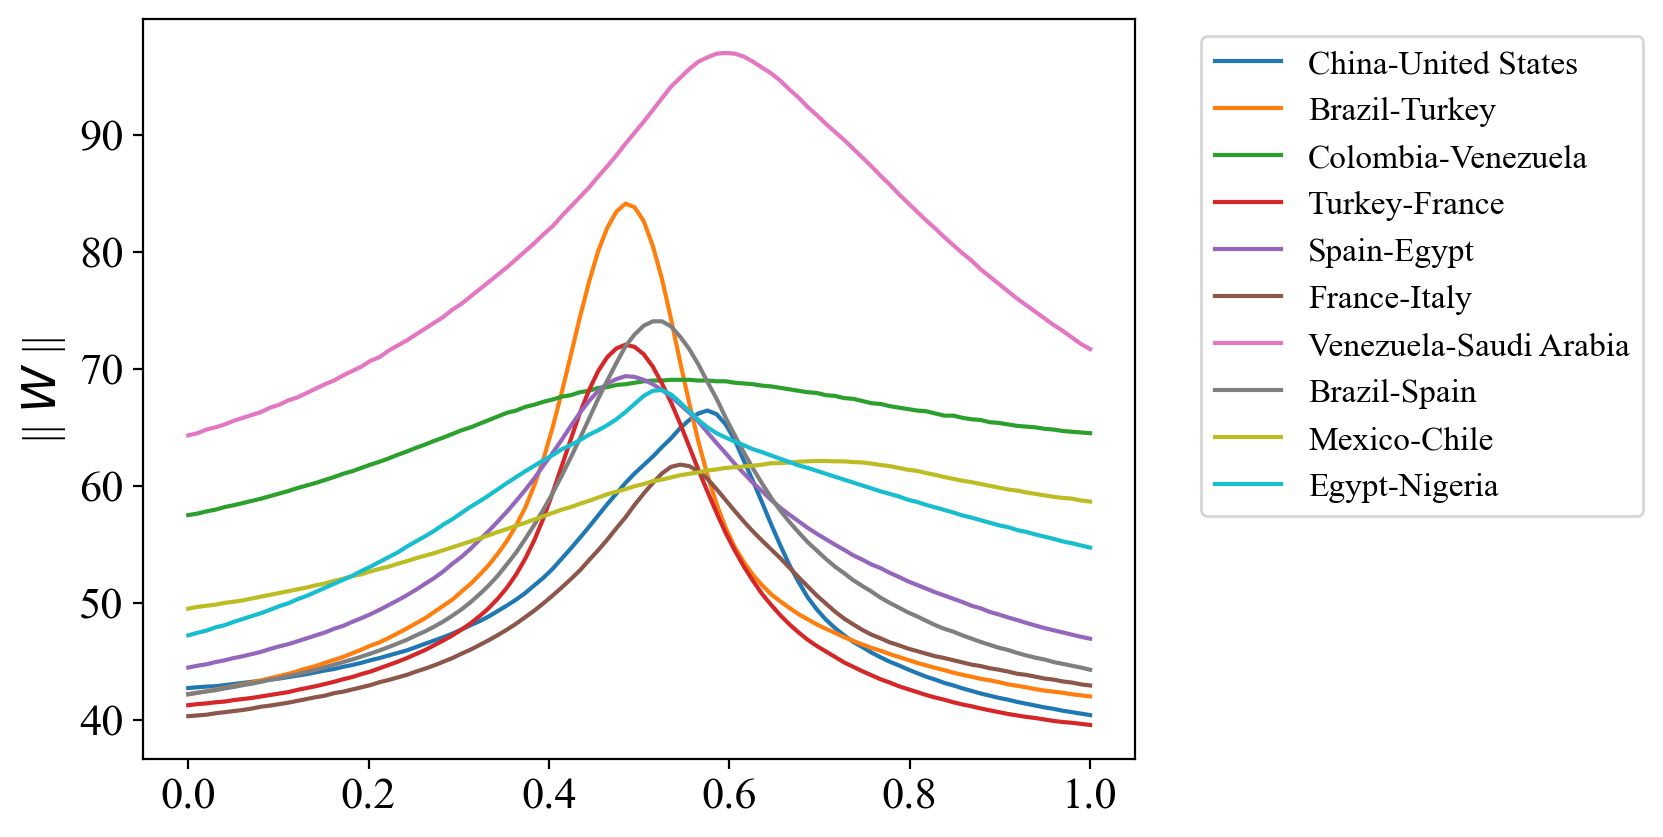

In [33]:
for trial, label in zip(W_norms, labels):
    plt.plot(np.linspace(0, 1, interpolation_steps), trial, label=label)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel("|| $W$ ||")

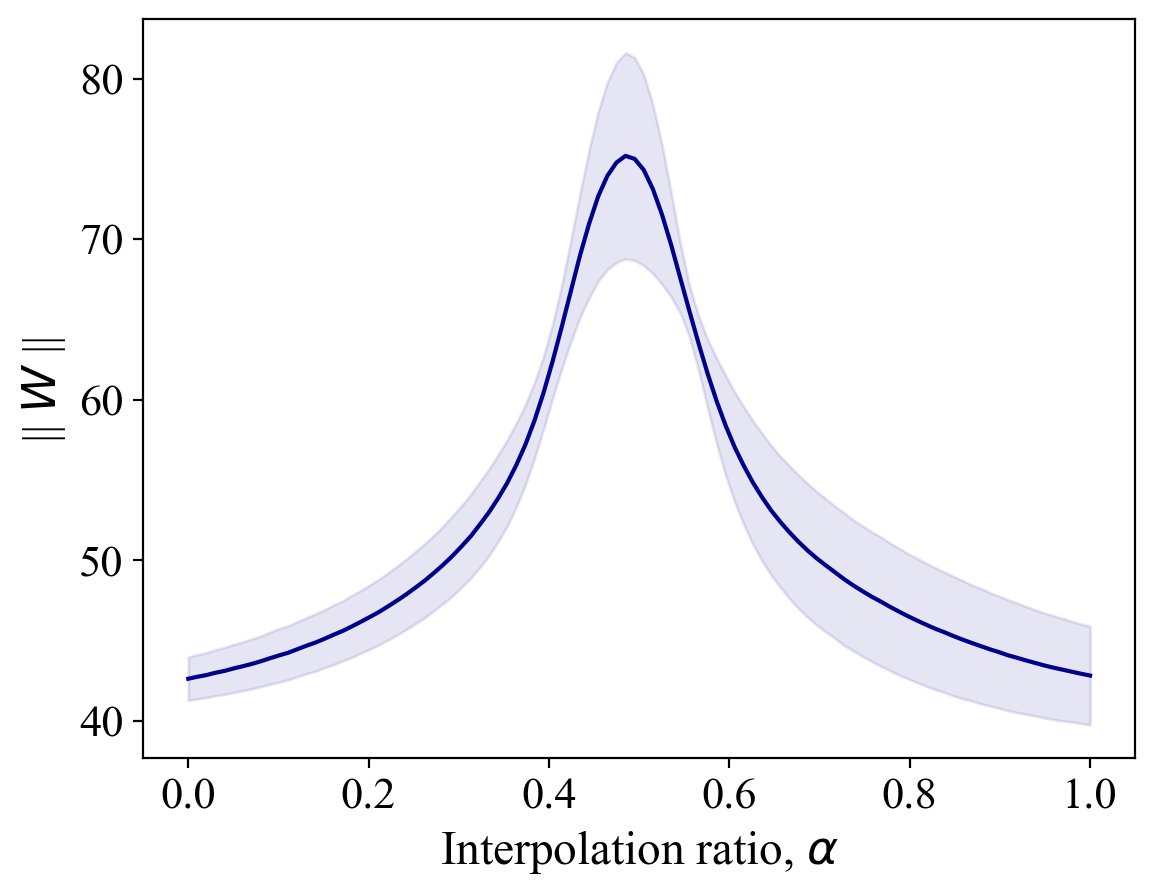

In [34]:
# filter_trials = ["South Korea-Brazil", "Brazil-Nigeria", "Egypt-South Korea", "Chile-Egypt"]
filter_trials = ["Brazil-Turkey", "Turkey-France", "Brazil-France", "Spain-Egypt"]
trial_results = []
for trial, label in zip(W_norms, labels):
    if label not in filter_trials:
        continue
    trial_results.append(trial)
    # plt.plot(np.linspace(0, 1, interpolation_steps), trial, label=label)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

trial_results = np.array(trial_results)
trial_results_mean = trial_results.mean(axis=0)
trial_results_std = trial_results.std(axis=0)


fig_dir = "figures/figs"
#####################################################################################
plt.rcdefaults()
color = "darkblue"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=MEDIUM_SIZE+1)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=50)  # fontsize of the figure title
#####################################################################################

x = np.linspace(0, 1, interpolation_steps)
plt.plot(x, trial_results_mean, color=color)
plt.fill_between(x, trial_results_mean - trial_results_std, trial_results_mean + trial_results_std, alpha=0.1, color = color)
plt.xlabel("Interpolation ratio, $\\alpha$")
plt.ylabel("|| $W$ ||")

plt.savefig(f"{fig_dir}/j_underestimation.pdf", bbox_inches="tight")

Text(0, 0.5, '|| $W @ \\Delta h$ ||')

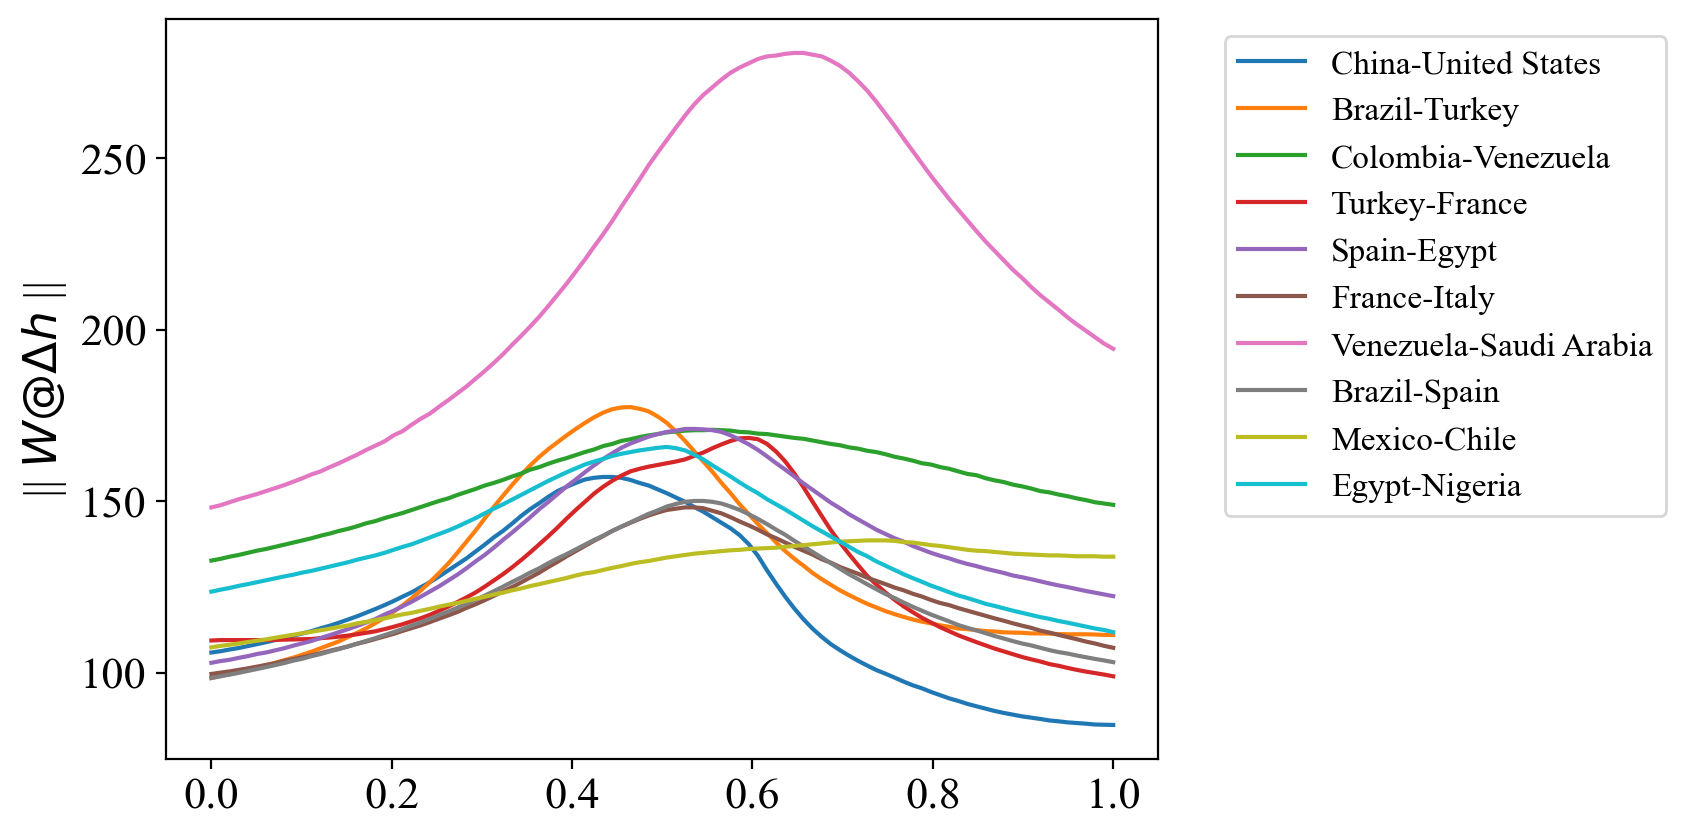

In [35]:
# J(h2 - h1)
for trial, label in zip(J_delta_h, labels):
    plt.plot(np.linspace(0, 1, interpolation_steps), trial, label=label)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel("|| $W @ \Delta h$ ||")

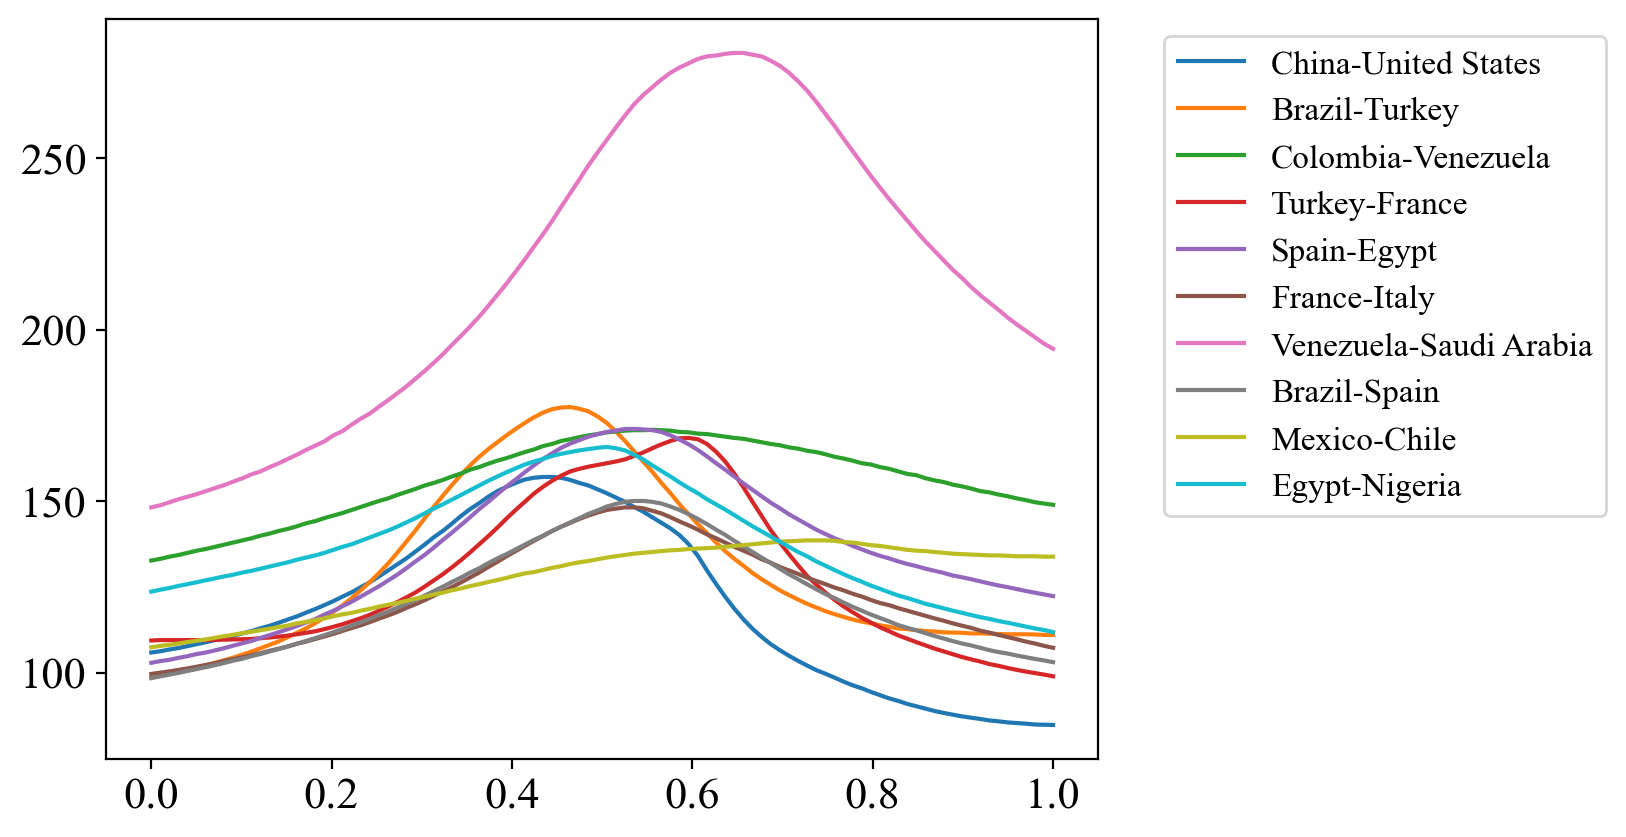

In [26]:
# J @ (h1 + h2)/2
for trial, label in zip(J_delta_h, labels):
    plt.plot(np.linspace(0, 1, interpolation_steps), trial, label=label)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

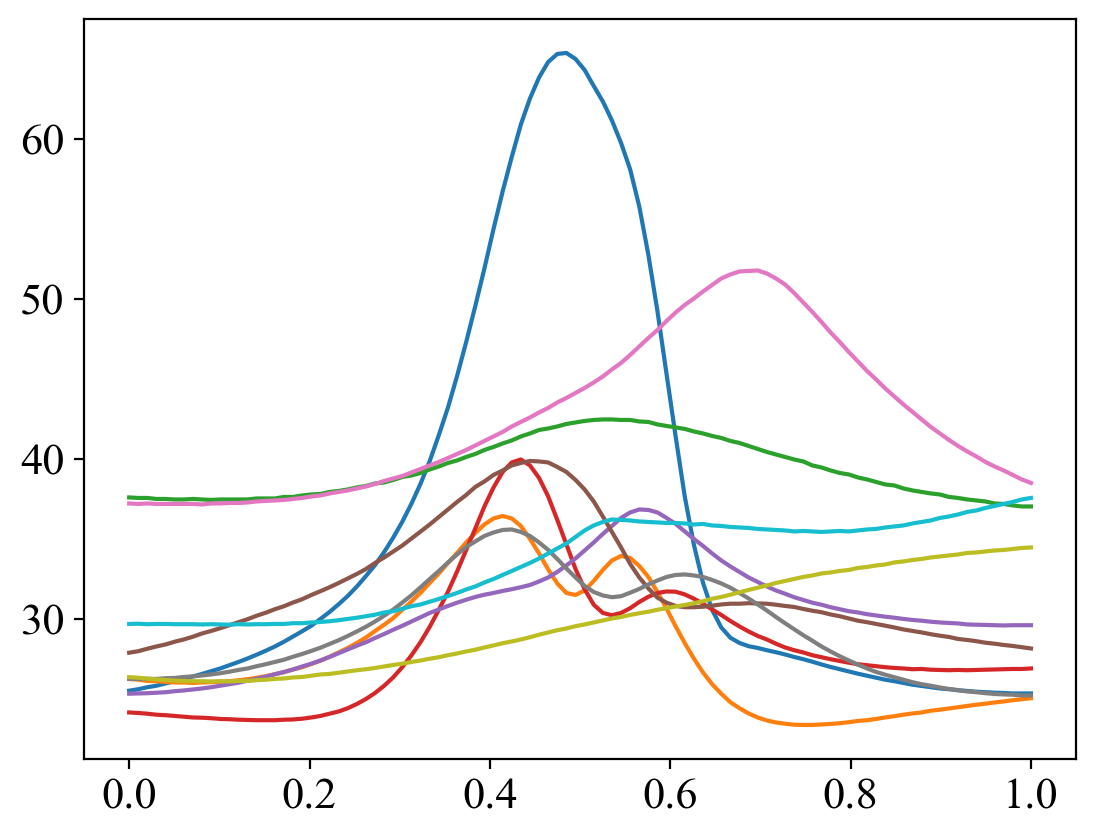

In [27]:
for trial in Jh_norms:
    plt.plot(np.linspace(0, 1, interpolation_steps), trial)